hello 

In [98]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [99]:
dfB = pd.read_csv("Data-Table 1.csv",thousands=',')
dfW = pd.read_csv("london_weather.csv",parse_dates=["date"])

In [100]:
dfB = dfB.drop(columns = ['Unnamed: 2','Month','Number of Bicycle Hires.1', 'Unnamed: 5', 'Year',
       'Number of Bicycle Hires.2', 'Unnamed: 8', 'Month.1',
       'Average Hire Time (mins)', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'])


In [104]:
dfB = dfB.convert_dtypes()
dfB["Day"] = pd.to_datetime(dfB["Day"])
dfW = dfW.convert_dtypes()
dfW["date"] = pd.to_datetime(dfW["date"])

dfB["Day"] = dfB["Day"].dt.strftime('%Y-%m-%d')
dfW["date"] = dfW["date"].dt.strftime('%Y-%m-%d')


In [107]:
dfW = dfW[~(dfW['date'] < '2010-07-30')]
dfB = dfB[~(dfB['Day'] > '2020-12-31')]

In [108]:
dfB = dfB.set_index("Day")
dfW = dfW.set_index("date")

In [109]:
dfW.info()
dfB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3808 entries, 2010-07-30 to 2020-12-31
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       3805 non-null   Int64  
 1   sunshine          3808 non-null   Float64
 2   global_radiation  3802 non-null   Int64  
 3   max_temp          3802 non-null   Float64
 4   mean_temp         3801 non-null   Float64
 5   min_temp          3806 non-null   Float64
 6   precipitation     3802 non-null   Float64
 7   pressure          3808 non-null   Int64  
 8   snow_depth        3171 non-null   Int64  
dtypes: Float64(5), Int64(4)
memory usage: 331.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 3808 entries, 2010-07-30 to 2020-12-31
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Number of Bicycle Hires  3808 non-null   Int64
dtypes: Int64(1)
memory usage: 63.2+ KB


<AxesSubplot: xlabel='date', ylabel='snow_depth'>

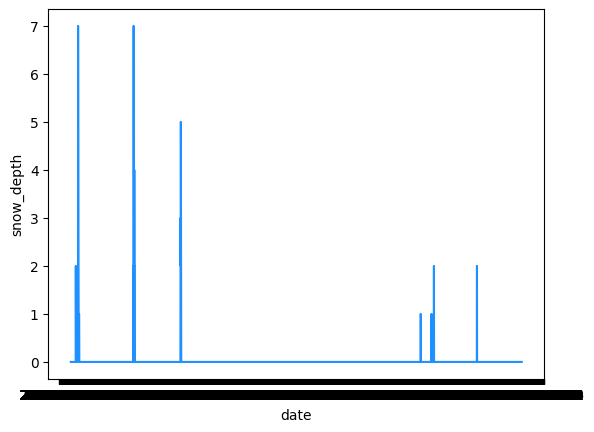

In [110]:
sns.lineplot(x=dfW.index, y=dfW["snow_depth"],  color='dodgerblue')

<AxesSubplot:xlabel='ob_end_time', ylabel='prcp_amt'>

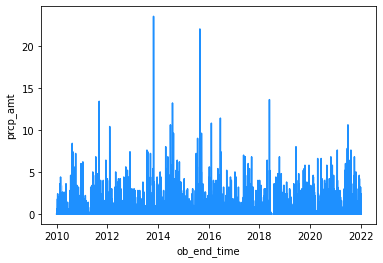

In [119]:
sns.lineplot(x=dfW["ob_end_time"], y=dfW["prcp_amt"],  color='dodgerblue')

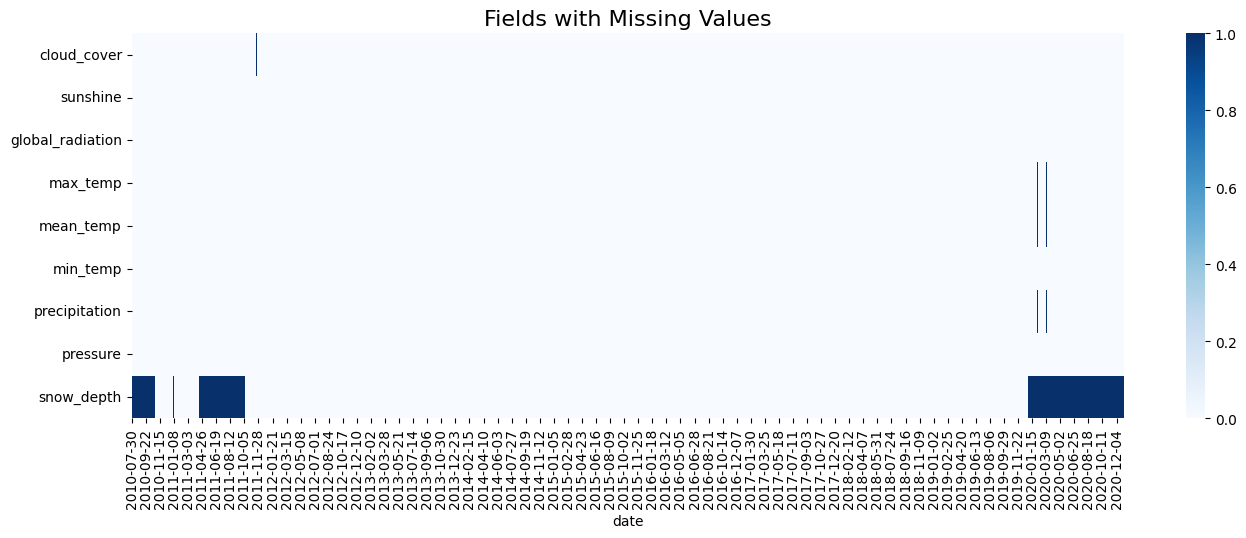

In [111]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(dfW.isna().transpose(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
plt.show()

In [77]:
dfW.isna().sum()


cloud_cover           3
sunshine              0
global_radiation      6
max_temp              6
mean_temp             7
min_temp              2
precipitation         6
pressure              0
snow_depth          637
dtype: int64

In [78]:
dfW["cloud_cover"] = dfW["cloud_cover"].values.astype(float)
dfW["global_radiation"] = dfW["global_radiation"].values.astype(float)
dfW["max_temp"] = dfW["max_temp"].values.astype(float)
dfW["mean_temp"] = dfW["mean_temp"].values.astype(float)
dfW["min_temp"] = dfW["min_temp"].values.astype(float)
dfW["precipitation"] = dfW["precipitation"].values.astype(float)
dfW["snow_depth"] = dfW["snow_depth"].values.astype(float)


dfW.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3808 entries, 2010-07-30 to 2020-12-31
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       3805 non-null   float64
 1   sunshine          3808 non-null   Float64
 2   global_radiation  3802 non-null   float64
 3   max_temp          3802 non-null   float64
 4   mean_temp         3801 non-null   float64
 5   min_temp          3806 non-null   float64
 6   precipitation     3802 non-null   float64
 7   pressure          3808 non-null   Int64  
 8   snow_depth        3171 non-null   float64
dtypes: Float64(1), Int64(1), float64(7)
memory usage: 434.0 KB


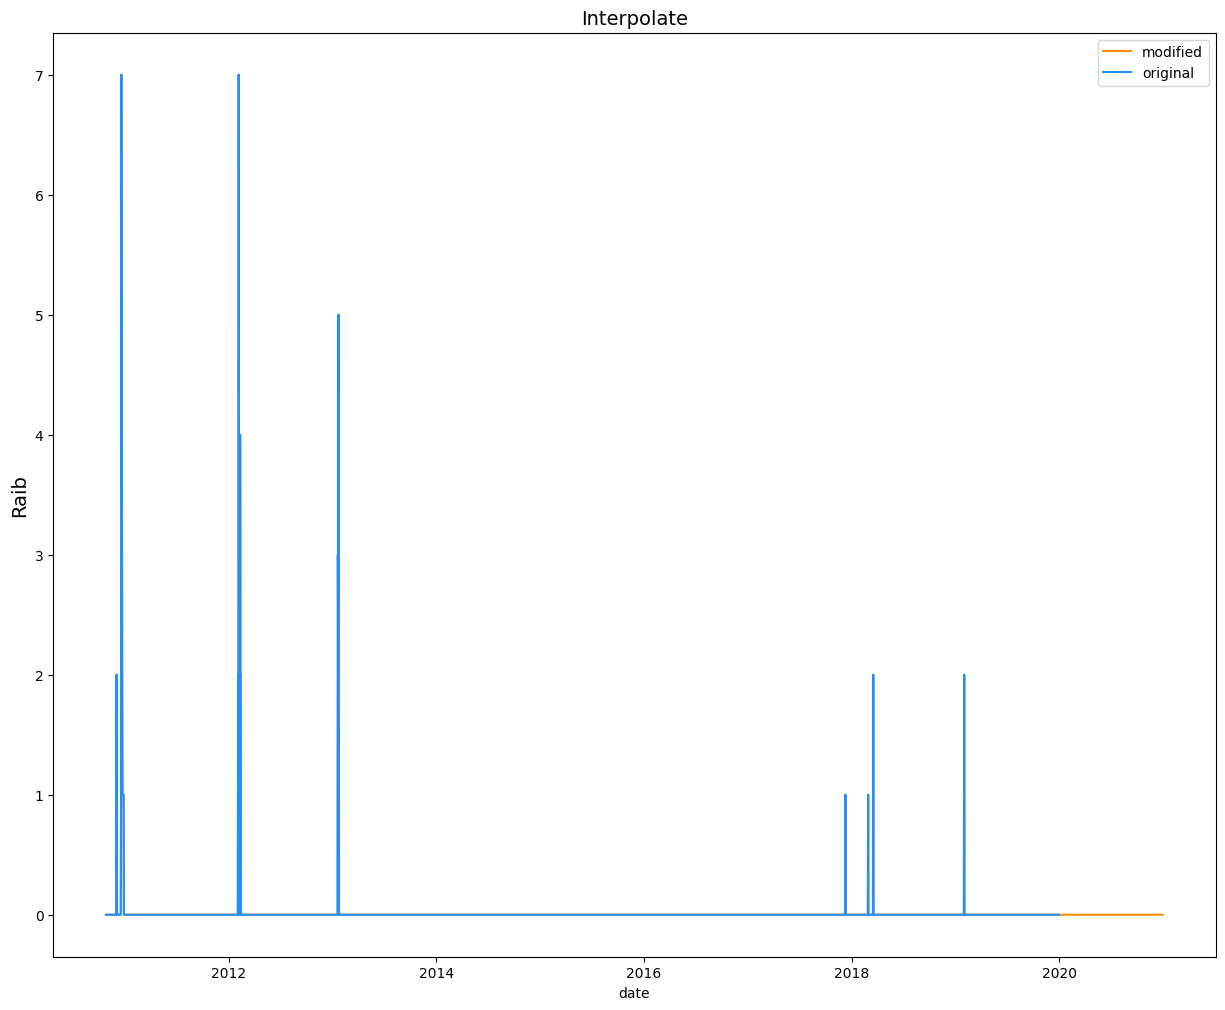

In [79]:
data = dfW
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))
sns.lineplot(x=data.index, y=data.snow_depth.interpolate(),color='darkorange', label = 'modified')
sns.lineplot(x=data.index, y=data.snow_depth.fillna(np.inf),  color='dodgerblue', label = 'original')
ax.set_title(f'Interpolate', fontsize=14)
ax.set_ylabel(ylabel='Raib', fontsize=14)
plt.show()

In [66]:
dfW['cloud_cover'] = dfW['cloud_cover'].interpolate()
dfW['global_radiation'] = dfW['global_radiation'].interpolate()
dfW['max_temp'] = dfW['max_temp'].interpolate()
dfW['mean_temp'] = dfW['mean_temp'].interpolate()
dfW['min_temp'] = dfW['min_temp'].interpolate()
dfW['precipitation'] = dfW['precipitation'].interpolate()
dfW['snow_depth'] = dfW['snow_depth'].interpolate()


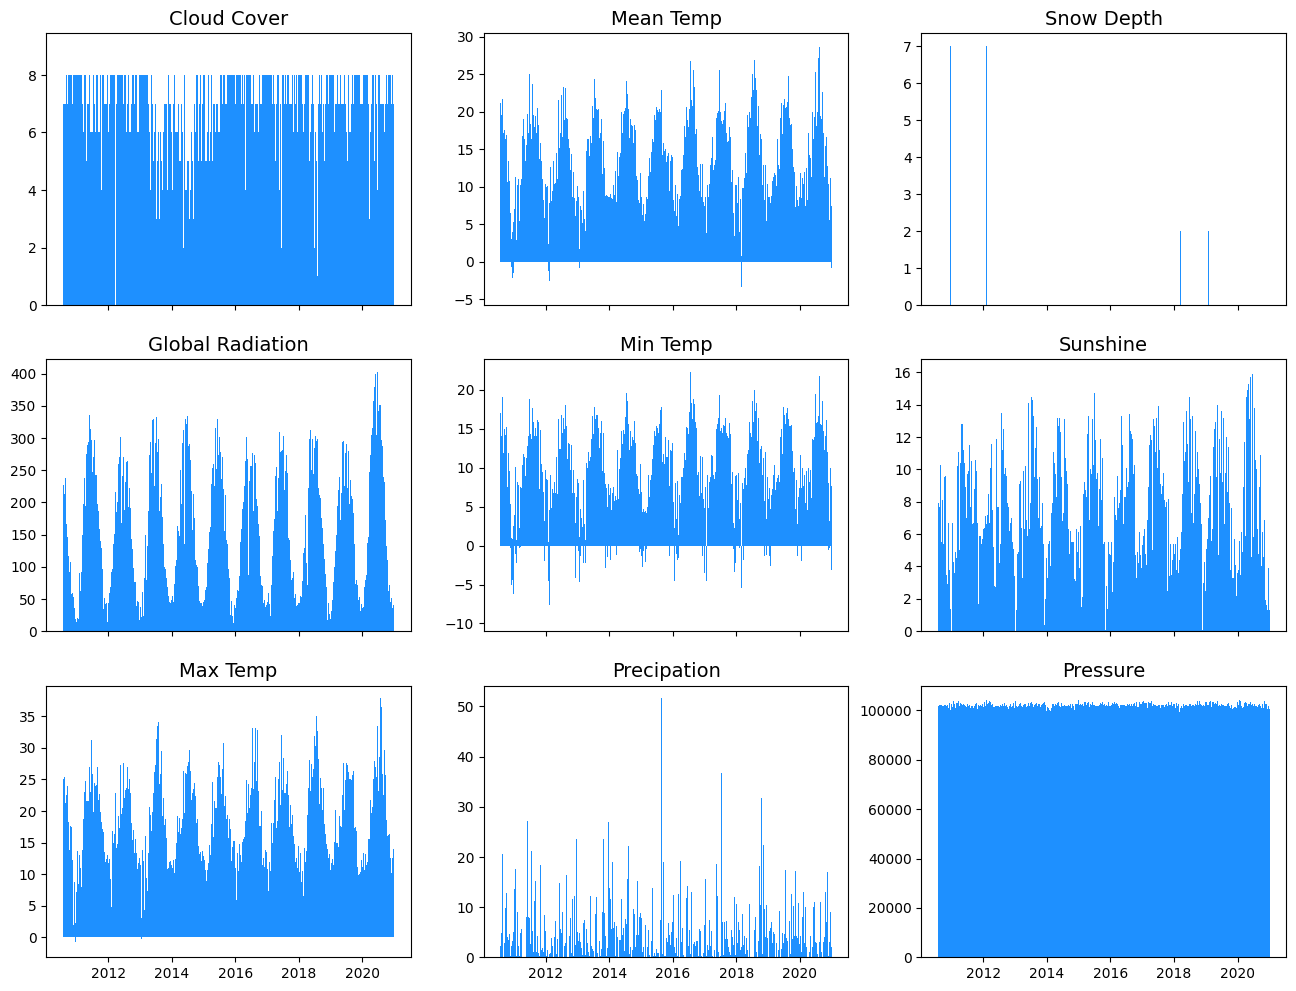

In [83]:
fig, ax = plt.subplots(ncols=3, nrows=3, sharex=True, figsize=(16,12))

ax[0][0].bar(dfW.index, dfW.cloud_cover, width=5, color='dodgerblue')
ax[0][0].set_title('Cloud Cover', fontsize=14)
ax[1][0].bar(dfW.index, dfW.global_radiation, width=5, color='dodgerblue')
ax[1][0].set_title('Global Radiation', fontsize=14)
ax[2][0].bar(dfW.index, dfW.max_temp, width=5, color='dodgerblue')
ax[2][0].set_title('Max Temp', fontsize=14)
ax[0][1].bar(dfW.index, dfW.mean_temp, width=5, color='dodgerblue')
ax[0][1].set_title('Mean Temp', fontsize=14)
ax[1][1].bar(dfW.index, dfW.min_temp, width=5, color='dodgerblue')
ax[1][1].set_title('Min Temp', fontsize=14)
ax[2][1].bar(dfW.index, dfW.precipitation, width=5, color='dodgerblue')
ax[2][1].set_title('Precipation', fontsize=14)
ax[0][2].bar(dfW.index, dfW.snow_depth, width=5, color='dodgerblue')
ax[0][2].set_title('Snow Depth', fontsize=14)
ax[1][2].bar(dfW.index, dfW.sunshine, width=5, color='dodgerblue')
ax[1][2].set_title('Sunshine', fontsize=14)
ax[2][2].bar(dfW.index, dfW.pressure, width=5, color='dodgerblue')
ax[2][2].set_title('Pressure', fontsize=14)

plt.show()

<AxesSubplot: >

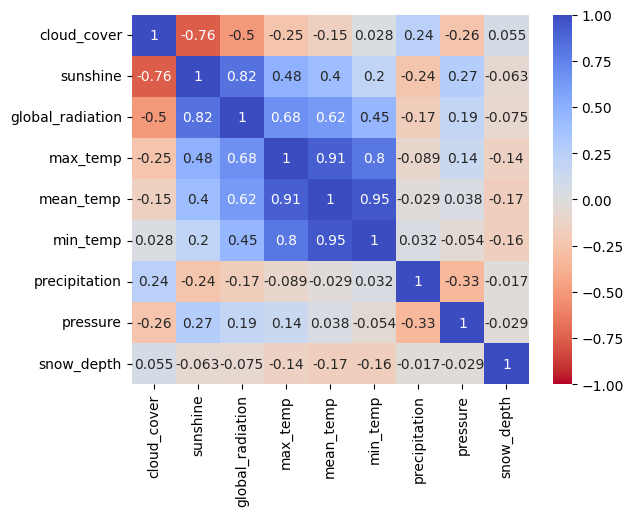

In [84]:
corrmat = dfW.corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')

In [113]:
dfB["Number of Bicycle Hires"] = dfB["Number of Bicycle Hires"].astype(float)
#cor =  dfB["Number of Bicycle Hires"].apply(dfW.corrwith)
#print(cor)
#sns.heatmap(cor, annot=True, cmap='coolwarm_r')